In [1]:
version = 'v2'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, re
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_Jpsi = 3.09691

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [19]:
dataDir = '../data/cmsRD'
# RDdsLoc = glob(dataDir + '/ParkingBPH*/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_200607_CAND.root')
RDdsLoc = glob(dataDir + '/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_200607_CAND.root')
# treeRD = rt.TChain('TnP/T')
# for l in dsLoc:
#     treeRD.Add(l)
fileRD = rt.TFile.Open(RDdsLoc[0], 'READ')
treeRD = fileRD.Get('TnP/T')
print 'Data probe muons:', treeRD.GetEntries()

Data probe muons: 157508806


In [8]:
mcDir = '../data/cmsMC_private/BP_Tag-Probe_B0_JpsiKst_Hardbbbar_evtgen_HELAMP_PUc0_10-2-3'
MCdsLoc = glob(mcDir + '/ntuples_TagAndProbe/merged/out_CAND.root')
fileMC = rt.TFile.Open(MCdsLoc[0], 'READ')
treeMC = fileMC.Get('TnP/T')
print 'MC probe muons:', treeMC.GetEntries()

MC probe muons: 6348206


Explore kinematic distribution to choose a binning

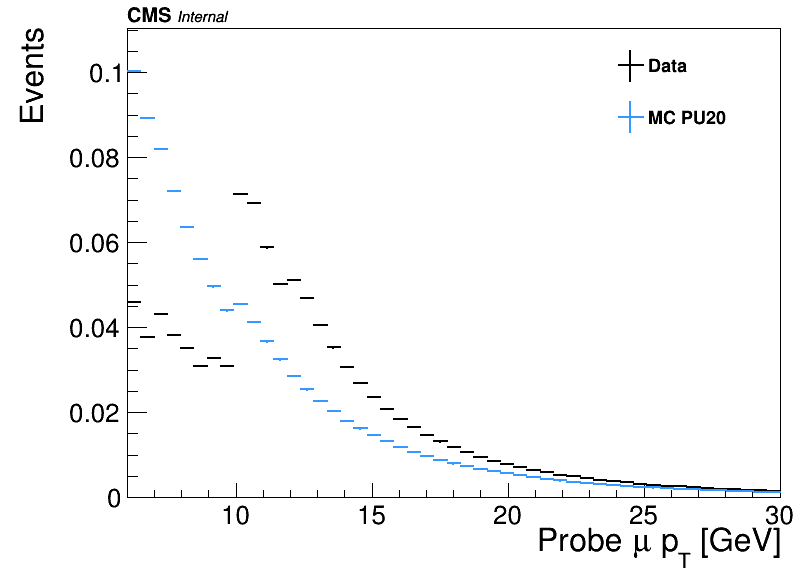

In [9]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu p_{T} [GeV]', 'Events'],
                binning=np.linspace(start=6, stop=30, num=50)
               )
treeRD.Project('h', 'mProbe_pt')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PU20', binning=h_list[0].binning)
treeMC.Project('h2', 'mProbe_pt')
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()
# c.SetLogy()
# c.SetLogx()

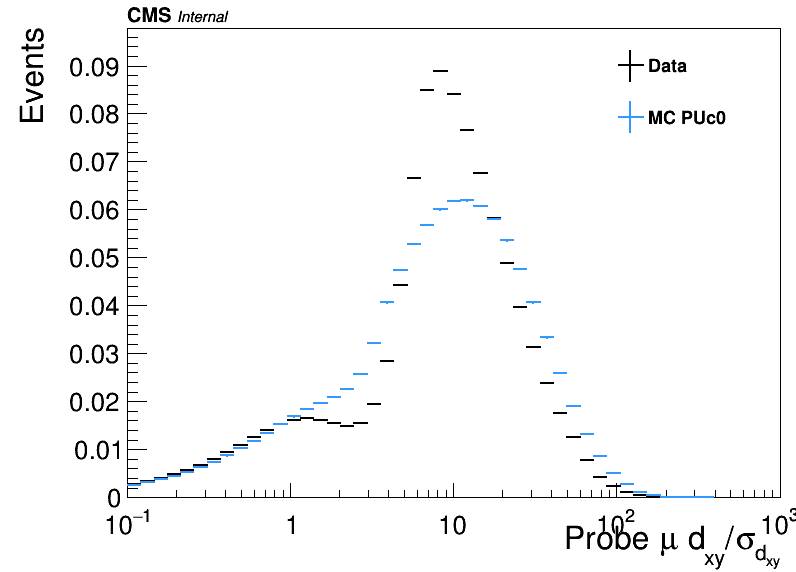

In [10]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu d_{xy}/#sigma_{d_{xy}}', 'Events'],
                binning=np.logspace(start=-1, stop=3, num=50)
               )
treeRD.Project('h', 'mProbe_sigdxy')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PUc0', binning=h_list[0].binning)
treeMC.Project('h2', 'mProbe_sigdxy')
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()
# c.SetLogy()
c.SetLogx()

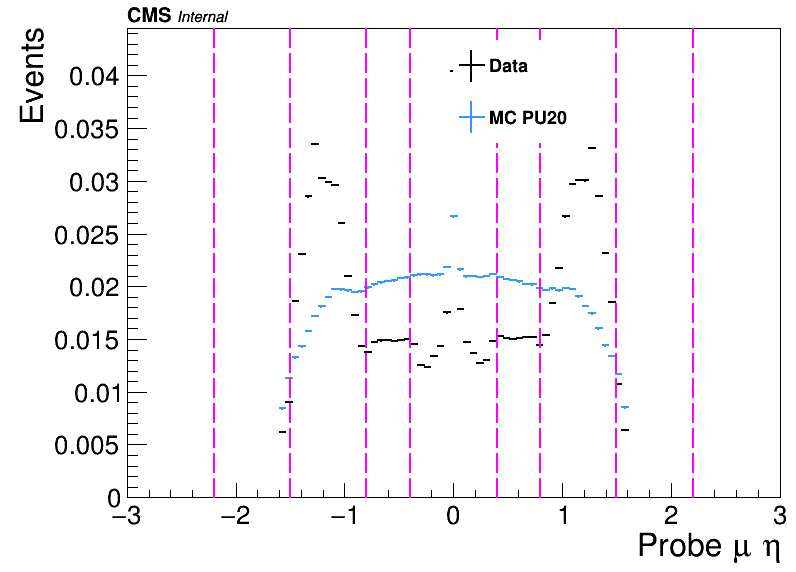

In [11]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu #eta', 'Events'],
                binning=np.linspace(start=-3, stop=3, num=100)
               )
treeRD.Project('h', 'mProbe_eta')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PU20', binning=h_list[0].binning)
treeMC.Project('h2', 'mProbe_eta')
h_list.append(h)

leg = rt.TLegend(0.57, 0.75, 0.75, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
for e in [0.4, 0.8, 1.5, 2.2]:
    cl.DrawLine(e, 0, e, m)
    cl.DrawLine(-e, 0, -e, m)
leg.Draw()
c.Draw()

# Efficiency functions

In [12]:
# def fitJpsi(inT, psCut, probeTrigger, mJpsiWindow=0.25, mBins=100, rightText=None, verbose=False):
#     arrSel = rtnp.tree2array(inT, branches=['massInv'], 
#                              selection=psCut + ' && fabs(massInv - {}) < {}'.format(m_Jpsi, mJpsiWindow))
#     T = rtnp.array2tree(arrSel)
#     del arrSel
#     if verbose: print 'Skimmed tree created'
    
#     h = create_TH1D(np.zeros(0), name='h',
#                     title='',
#                     axis_title=['mass(#mu#mu) [GeV]', 'Events'],
#                     binning=[mBins, m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow]
#                    )
#     T.Project('h', 'massInv')
#     if h.GetMinimum() == 0:
#         if verbose: print 'Trying reduce the number of bins'
#         mBins = int(mBins*0.5)
#         h = create_TH1D(np.zeros(0), name='h',
#                     title='',
#                     axis_title=['mass(#mu#mu) [GeV]', 'Events'],
#                     binning=[mBins, m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow]
#                    )
#         T.Project('h', 'massInv')
#     h.Sumw2()
#     N_tot = h.Integral()

#     mass = rt.RooRealVar('massInv', 'Mass(#mu#mu)', m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow, 'GeV')

#     mean = rt.RooRealVar('mean', '#mu', m_Jpsi, m_Jpsi-0.01, m_Jpsi+0.01, 'GeV')
#     sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.01, 0.05, 'GeV') 
#     sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.01, 0.07, 'GeV') 
#     gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
#     gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
#     fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.0, 1.0)
#     pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))
#     nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 10*N_tot)
#     pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

#     lam = rt.RooRealVar('lam', '#lambda', -5, -100, -0.1, 'GeV^{-1}')
#     pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)
#     nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 10*N_tot)
#     pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

#     pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
    
#     unbinnedUsed = False
#     if h.GetMinimum() == 0 or h.Integral() < 2*h.binning[0]:
#         if verbose: print 'Using unbinned likelihood ({:.0f} events)'.format(h.Integral())
#         data = rt.RooDataSet('d', 'data', T, rt.RooArgSet(mass))
#         unbinnedUsed = True
#     else:
#         data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)
#         if verbose: print 'Using binned likeihood'
    
#     fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())
    
#     frame = mass.frame(rf.Title(""), rf.Bins(h.binning[0]))
#     dataPlot = data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), 
#                            rf.MarkerColor(1), rf.LineColor(1), rf.MarkerStyle(15))
    
#     pdf_tot.plotOn(frame, rf.LineColor(rt.kBlack), rf.LineWidth(1))

#     dof = fr.floatParsFinal().getSize()
#     chi2 = frame.chiSquare(dof)*dof
#     pval = rt.ROOT.Math.chisquared_cdf_c(chi2, dof)
#     if verbose: print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2, dof, pval)

#     pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
#     pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

#     x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.04
#     x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.36
#     pTxt = rt.TPaveText(x_min, 0.25*dataPlot.GetMaximum(), x_max, 0.9*dataPlot.GetMaximum())
#     pTxt.SetBorderSize(0)
#     pTxt.SetFillStyle(0)
#     pTxt.SetTextAlign(11)
#     pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2, dof, pval))
#     pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

#     pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
#     pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
#     pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
#     pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))
#     frame.addObject(pTxt)
    
#     if not rightText is None:
#         x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.65
#         x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.95
#         pTxtR = rt.TPaveText(x_min, 0.5*dataPlot.GetMaximum(), x_max, 0.7*dataPlot.GetMaximum())
#         pTxtR.SetBorderSize(0)
#         pTxtR.SetFillStyle(0)
#         for s in rightText:
#             pTxtR.AddText(s)
#         frame.addObject(pTxtR)
    
#     return frame, [nsig.getVal(), nsig.getError()], [chi2, dof, pval]

In [13]:
# def analyzeBin(idx, reloadTree=True, verbose=False):
#     print idx, 'started'
#     if reloadTree:
#         fileTmp = None
#         if len(dataset_loc) == 1:
#             fileTmp = rt.TFile(dataset_loc[0], 'READ')
#             T = fileTmp.Get('TnP/T')
#         else:
#             raise
#     psCut = []
#     lim = {}
#     psStrings = []
#     for n, i in idx.iteritems():
#         lim[n] = [binning[n][i], binning[n][i+1]]
#         psCut.append('fabs(fabs(mProbe_{}) - {}) < {}'.format(n, np.mean(lim[n]), 0.5*(lim[n][1]-lim[n][0])))
#         psS = '{:.1f} < '.format(lim[n][0])
#         if n == 'eta':
#             psS += '|#eta|'
#         elif n == 'pt':
#             psS += 'p_{T}/GeV'
#         elif n == 'sigdxy':
#             psS += 'IP'
#         else: 
#             raise
#         psS += ' < {:.1f}'.format(lim[n][1])
#         psStrings.append(psS)
#     psCut = ' && '.join(psCut + ['prescale'+probeTrigger[4:] + ' > 0'])

#     rt.TGaxis.SetMaxDigits(3)

#     if verbose: 
#         print ' --- Total ---'
#         print psCut
#     st = time.time()
#     frameTot, nSigTot, pValTot = fitJpsi(T, psCut, probeTrigger,
#                                          rightText=['All '] + psStrings,
#                                          verbose=verbose
#                                         )
#     if verbose: 
#         print 'Time: {:.1f} s'.format(time.time()-st)
#         print ' --- Passed ---'
#         print psCut + ' && mProbe_' + probeTrigger + ' == 1'
#     st = time.time()
#     framePassed, nSigPass, pValPass = fitJpsi(T, psCut + ' && mProbe_' + probeTrigger + ' == 1', probeTrigger,
#                                               rightText=['Passed '+probeTrigger] + psStrings,
#                                               verbose=verbose
#                                              )
#     if verbose: print 'Time: {:.1f} s'.format(time.time()-st)
#     cTag = '_' + '_'.join([str(idx[k]) for k in np.sort(idx.keys())])
#     c = rt.TCanvas('c'+cTag, 'c'+cTag, 50, 50, 1200, 600)
#     c.SetTickx(0)
#     c.SetTicky(0)
#     c.Divide(2)

#     p = c.cd(1)
#     frameTot.Draw()
#     CMS_lumi.CMS_lumi(p, -1, 33)
#     p = c.cd(2)
#     framePassed.Draw()
#     CMS_lumi.CMS_lumi(p, -1, 33)
    
#     imgLoc = '../data/calibration/triggerScaleFactors/figFit'+dataset+'/{}'.format(probeTrigger)
#     if not os.path.isdir(imgLoc):
#         os.makedirs(imgLoc)
#         print 'Creating', imgLoc
#     c.SaveAs(imgLoc + '/'+ '_'.join([k+str(idx[k]) for k in np.sort(idx.keys())]) +'.png')
#     if reloadTree and not fileTmp is None:
#         fileTmp.Close()
#     print idx, 'done'
#     return c, idx, nSigTot, pValTot, nSigPass, pValPass

In [14]:
def analyzeBin(idx, reloadTree=True, verbose=False):
    print idx, 'started'
    if reloadTree:
        fileTmp = None
        if len(dataset_loc) == 1:
            fileTmp = rt.TFile(dataset_loc[0], 'READ')
            T = fileTmp.Get('TnP/T')
        else:
            raise
    psCut = []
    lim = {}
    psStrings = []
    for n, i in idx.iteritems():
        lim[n] = [binning[n][i], binning[n][i+1]]
        psCut.append('fabs(fabs(mProbe_{}) - {}) < {}'.format(n, np.mean(lim[n]), 0.5*(lim[n][1]-lim[n][0])))
        psS = '{:.1f} < '.format(lim[n][0])
        if n == 'eta':
            psS += '|#eta|'
        elif n == 'pt':
            psS += 'p_{T}/GeV'
        elif n == 'sigdxy':
            psS += 'IP'
        else: 
            raise
        psS += ' < {:.1f}'.format(lim[n][1])
        psStrings.append(psS)
    psCut = ' && '.join(psCut + ['prescale'+probeTrigger[4:] + ' > 0'])

    if verbose: 
        print ' --- Total ---'
        print psCut
    st = time.time()
    nSigTot = T.GetEntries(psCut)
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
        print ' --- Passed ---'
        print psCut + ' && mProbe_' + probeTrigger + ' == 1'
    st = time.time()
    nSigPass = T.GetEntries(psCut + ' && mProbe_' + probeTrigger + ' == 1')
    
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
    if reloadTree and not fileTmp is None:
        fileTmp.Close()
    print idx, 'done'
    return idx, nSigTot, nSigPass

# Run the fit in each bin

In [21]:
dataset = 'RD'
if dataset == 'RD':
    CMS_lumi.extraText = "     Internal"
    T = treeRD
    dataset_loc = RDdsLoc
elif dataset == 'MC':
    CMS_lumi.extraText = "     Simulation Internal"
    T = treeMC
    dataset_loc = MCdsLoc
    

In [22]:
probeTrigger = 'HLT_Mu7_IP4'
binning = {'pt': array('d', [5.5, 6.5, 7, 7.3, 7.6, 8, 9, 12, 25]),
           'eta': array('d', [0, 0.4, 0.8, 1.5]),
           'sigdxy': array('d', [3, 4, 4.5, 6, 10, 200])
          }

# probeTrigger = 'HLT_Mu9_IP6'
# binning = {'pt': array('d', [8, 8.5, 9, 10, 11, 12, 20]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 6, 7, 10, 200])
#           }

# probeTrigger = 'HLT_Mu12_IP6'
# binning = {'pt': array('d', [10, 11, 12, 13, 15, 20, 30, 50, 200]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 6, 7, 10, 200])
#           }

In [23]:
h2 = {}
for var, cat in itertools.product(['N', 'Chi2'], ['tot', 'pass']):
    h2[var+cat] = rt.TH3D('h2'+var+cat, '', 
                          len(binning['pt'])-1, binning['pt'], 
                          len(binning['sigdxy'])-1, binning['sigdxy'], 
                          len(binning['eta'])-1, binning['eta'],)

In [24]:
start = time.time()
testOutput = analyzeBin({'pt': 2, 'sigdxy':2, 'eta':0}, verbose=True)
print testOutput
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

{'eta': 0, 'sigdxy': 2, 'pt': 2} started
 --- Total ---
fabs(fabs(mProbe_eta) - 0.2) < 0.2 && fabs(fabs(mProbe_sigdxy) - 5.25) < 0.75 && fabs(fabs(mProbe_pt) - 7.15) < 0.15 && prescaleMu7_IP4 > 0
Time: 219.7 s
 --- Passed ---
fabs(fabs(mProbe_eta) - 0.2) < 0.2 && fabs(fabs(mProbe_sigdxy) - 5.25) < 0.75 && fabs(fabs(mProbe_pt) - 7.15) < 0.15 && prescaleMu7_IP4 > 0 && mProbe_HLT_Mu7_IP4 == 1
Time: 132.2 s
{'eta': 0, 'sigdxy': 2, 'pt': 2} done
({'eta': 0, 'sigdxy': 2, 'pt': 2}, 108702L, 97705L)
Total time: 5.9 mins


In [25]:
inputs = []
for ipt in range(len(binning['pt'])-1):
    for iip in range(len(binning['sigdxy'])-1):
        for ieta in range(len(binning['eta'])-1):
            idx = {'pt': ipt, 'sigdxy':iip, 'eta': ieta}
            inputs.append(idx)
print 'Total bins:', len(inputs)

Total bins: 120


In [26]:
multiCpu = True
start = time.time()
if multiCpu:
    N_max = max(1, multiprocessing.cpu_count() - 8)
    N_request = min(len(inputs), N_max)
    print 'Parallelization factor:', N_request
    p = multiprocessing.Pool(N_request)
    output = p.map(analyzeBin, inputs)
else:
    output = []
    for i in inputs:
        output.append(analyzeBin(i, reloadTree=False, verbose=True))
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

Parallelization factor: 24
{'eta': 2, 'pt': 0, 'sigdxy': 0} started
{'eta': 0, 'pt': 0, 'sigdxy': 2} started
{'eta': 1, 'pt': 0, 'sigdxy': 1} started
{'eta': 2, 'pt': 0, 'sigdxy': 2} started
{'eta': 1, 'pt': 0, 'sigdxy': 3} started
{'eta': 2, 'pt': 0, 'sigdxy': 4} started
{'eta': 0, 'pt': 0, 'sigdxy': 4} started
{'eta': 0, 'pt': 1, 'sigdxy': 1} started
{'eta': 1, 'pt': 1, 'sigdxy': 0} started
{'eta': 0, 'pt': 0, 'sigdxy': 0} started
{'eta': 1, 'pt': 1, 'sigdxy': 2} started
{'eta': 2, 'pt': 1, 'sigdxy': 1} started
{'eta': 0, 'pt': 1, 'sigdxy': 3} started
{'eta': 1, 'pt': 1, 'sigdxy': 4} started
{'eta': 0, 'pt': 2, 'sigdxy': 0} started
{'eta': 2, 'pt': 1, 'sigdxy': 3} started
{'eta': 0, 'pt': 2, 'sigdxy': 2} started
{'eta': 2, 'pt': 2, 'sigdxy': 2} started
{'eta': 2, 'pt': 2, 'sigdxy': 0} started
{'eta': 1, 'pt': 2, 'sigdxy': 3} started
{'eta': 0, 'pt': 2, 'sigdxy': 4} started
{'eta': 1, 'pt': 3, 'sigdxy': 0} started
{'eta': 2, 'pt': 2, 'sigdxy': 4} started
{'eta': 1, 'pt': 2, 'sigdxy': 

{'eta': 2, 'pt': 7, 'sigdxy': 0} started
{'eta': 1, 'pt': 6, 'sigdxy': 3} done
{'eta': 2, 'pt': 6, 'sigdxy': 3} started
{'eta': 0, 'pt': 6, 'sigdxy': 4} done
{'eta': 1, 'pt': 6, 'sigdxy': 4} started
{'eta': 0, 'pt': 7, 'sigdxy': 3} done
{'eta': 1, 'pt': 7, 'sigdxy': 3} started
{'eta': 0, 'pt': 7, 'sigdxy': 1} done
{'eta': 1, 'pt': 7, 'sigdxy': 1} started
{'eta': 2, 'pt': 6, 'sigdxy': 4} done
{'eta': 0, 'pt': 7, 'sigdxy': 0} started
{'eta': 1, 'pt': 7, 'sigdxy': 2} done
{'eta': 2, 'pt': 7, 'sigdxy': 2} started
{'eta': 1, 'pt': 7, 'sigdxy': 4} done
{'eta': 2, 'pt': 7, 'sigdxy': 4} started
{'eta': 2, 'pt': 6, 'sigdxy': 2} done
{'eta': 0, 'pt': 6, 'sigdxy': 3} started
{'eta': 2, 'pt': 7, 'sigdxy': 3} done
{'eta': 0, 'pt': 7, 'sigdxy': 4} started
{'eta': 2, 'pt': 7, 'sigdxy': 1} done
{'eta': 0, 'pt': 7, 'sigdxy': 2} started
{'eta': 1, 'pt': 6, 'sigdxy': 2} done
{'eta': 1, 'pt': 6, 'sigdxy': 4} done
{'eta': 1, 'pt': 7, 'sigdxy': 3} done
{'eta': 0, 'pt': 7, 'sigdxy': 0} done
{'eta': 2, 'pt': 

In [27]:
for idx, nSigTot, nSigPass in output:
    ip = idx['pt']+1
    ii = idx['sigdxy']+1
    ie = idx['eta']+1
    h2['Ntot'].SetBinContent(ip, ii, ie, nSigTot)
    h2['Ntot'].SetBinError(h2['Ntot'].GetBin(ip, ii, ie), np.sqrt(nSigTot))
    h2['Npass'].SetBinContent(ip, ii, ie, nSigPass)
    h2['Npass'].SetBinError(h2['Npass'].GetBin(ip, ii, ie), np.sqrt(nSigPass))

In [28]:
if not rt.TEfficiency.CheckConsistency(h2['Npass'], h2['Ntot']): raise
pEff = rt.TEfficiency(h2['Npass'], h2['Ntot'])
pEff.SetStatisticOption(rt.TEfficiency.kFCP)
pEff.SetNameTitle('eff_'+probeTrigger, 'Efficience for '+probeTrigger)

tf = rt.TFile('../data/calibration/triggerScaleFactors/{}_{}_{}.root'.format(probeTrigger, dataset, version), 'RECREATE')
pEff.Write()
for h in h2.values():
    h.Write()
tf.Close()

In [29]:
# outCanvases = []
# rt.gStyle.SetOptTitle(1)
# rt.gStyle.SetTitleFillColor(0)
# rt.gStyle.SetTitleBorderSize(0)
# N_dof = h2['Chi2tot'].GetBinError(h2['Chi2tot'].GetBin(1,1,1))
# for iz in range(1, h2['Chi2tot'].GetNbinsZ()+1):
#     title = 'All candidates, {:.1f} < |#eta| < {:.1f}'.format(binning['eta'][iz-1], binning['eta'][iz])
#     h2_chi2tot = rt.TH2D('h2Chi2tot_'+str(iz), title, 
#                          len(binning['pt'])-1, -0.5, len(binning['pt'])-1.5, 
#                          len(binning['sigdxy'])-1, -0.5, len(binning['sigdxy'])-1.5
#                         )
#     h2_chi2tot.GetXaxis().SetTitle('Index p_{T}')
#     h2_chi2tot.GetYaxis().SetTitle('Index IP')
#     h2_chi2tot.GetZaxis().SetTitle('#chi^{2}/dof')
    
#     title = 'Passed, {:.1f} < |#eta| < {:.1f}'.format(binning['eta'][iz-1], binning['eta'][iz])
#     h2_chi2pass = rt.TH2D('h2Chi2pass_'+str(iz), title, 
#                          len(binning['pt'])-1, -0.5, len(binning['pt'])-1.5, 
#                          len(binning['sigdxy'])-1, -0.5, len(binning['sigdxy'])-1.5
#                         )
#     h2_chi2pass.GetXaxis().SetTitle('Index p_{T}')
#     h2_chi2pass.GetYaxis().SetTitle('Index IP')
#     h2_chi2pass.GetZaxis().SetTitle('#chi^{2}/dof')
    
#     for ix, iy in itertools.product(range(1, h2['Chi2tot'].GetNbinsX()+1), range(1, h2['Chi2tot'].GetNbinsY()+1)):
#         idx = h2['Chi2tot'].GetBin(ix, iy, iz)
#         h2_chi2tot.SetBinContent(ix, iy, h2['Chi2tot'].GetBinContent(idx)/7.)
#         h2_chi2pass.SetBinContent(ix, iy, h2['Chi2pass'].GetBinContent(idx)/7.)

#     c = rt.TCanvas('c_'+str(iz), 'c_'+str(iz), 50, 50, 1200, 500)
#     c.SetTickx(0)
#     c.SetTicky(0)
#     c.Divide(2)

#     p = c.cd(1)
#     h2_chi2tot.Draw('colz')
#     h2_chi2tot.GetZaxis().SetRangeUser(-5, 5)
#     p.SetTopMargin(0.09)
#     p.SetRightMargin(0.18)
#     cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5)
#     cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5)
#     cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5)
#     cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5)
    
#     p = c.cd(2)
#     h2_chi2pass.Draw('colz')
#     h2_chi2pass.GetZaxis().SetRangeUser(-5, 5)
#     p.SetTopMargin(0.09)
#     p.SetRightMargin(0.18)
#     cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5)
#     cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5)
#     cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5)
#     cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5)
    
    
#     c.Draw()
#     imgLoc = '../data/calibration/triggerScaleFactors/figFit'+dataset+'/{}'.format(probeTrigger)
#     c.SaveAs(imgLoc + '/' + 'chi2_eta{}.png'.format(iz-1))
#     outCanvases.append([c, h2_chi2tot, h2_chi2pass])

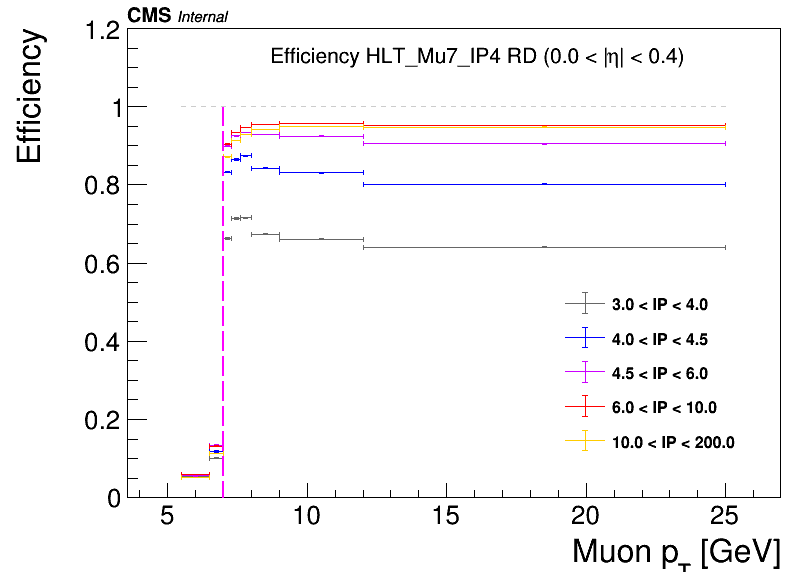

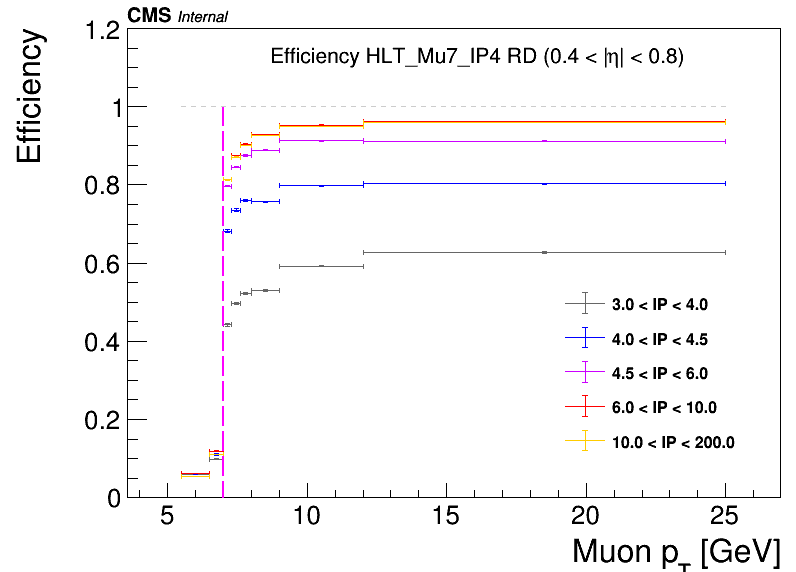

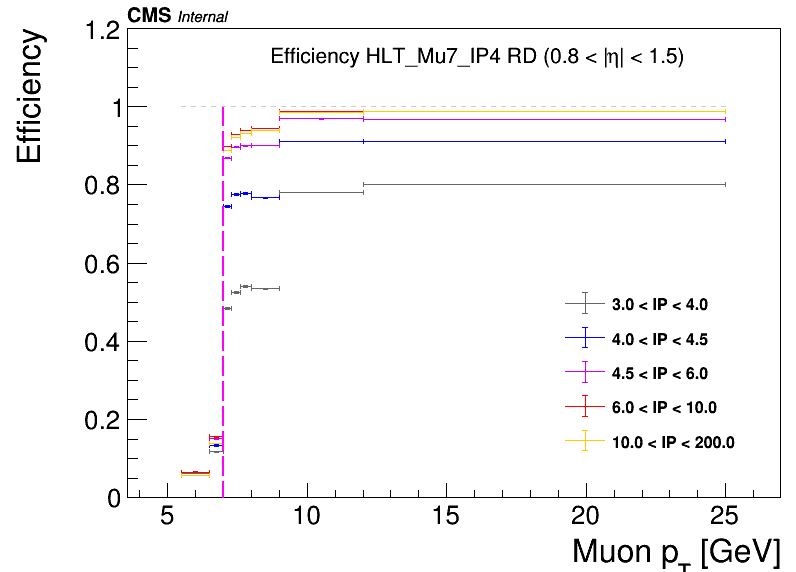

In [30]:
outCanvases = []
tdrstyle.setTDRStyle()
BRY_colors = [rt.kGray+2, rt.kBlue, rt.kViolet, rt.kRed, rt.kOrange, rt.kYellow+1]
hRef = h2['Npass']
for iz in range(1, hRef.GetNbinsZ()+1):
    title = 'Efficiency {} {} ({:.1f} < |#eta| < {:.1f})'.format(probeTrigger, dataset, binning['eta'][iz-1], binning['eta'][iz])
    
    leg = rt.TLegend(0.7, 0.2, 0.98, 0.5)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    gr2draw = []

    for iy in range(1, hRef.GetNbinsY()+1):
        gr = rt.TGraphAsymmErrors()
        for ix in range(1, hRef.GetNbinsX()+1):
            idx = pEff.GetGlobalBin(ix, iy, iz)
            x = binning['pt'][ix-1] + 0.5*(binning['pt'][ix] - binning['pt'][ix-1])
            gr.SetPoint(ix-1, x, pEff.GetEfficiency(idx))
            gr.SetPointError(ix-1, x-binning['pt'][ix-1], binning['pt'][ix]-x, 
                             pEff.GetEfficiencyErrorLow(idx), pEff.GetEfficiencyErrorUp(idx)
                            )
        gr.SetLineColor(BRY_colors[iy-1])
        gr.SetMarkerColor(BRY_colors[iy-1])
        leg.AddEntry(gr, '{:.1f} < IP < {:.1f}'.format(binning['sigdxy'][iy-1], binning['sigdxy'][iy]), 'lep')
        gr2draw.append(gr)
    
    M = 1.2
    m = 0
    gr2draw[0].GetYaxis().SetRangeUser(m ,M)
    c = drawOnCMSCanvas(CMS_lumi, gr2draw, ['AP'] + (len(gr2draw)-1)*['P'], tag='_eff'+str(iz))    
    gr2draw[0].GetYaxis().SetTitle('Efficiency')
    gr2draw[0].GetXaxis().SetTitle('Muon p_{T} [GeV]')
    leg.Draw()
#     c.SetLogx()
#     c.SetLogy()
#     m = 1e-3
#     M = 5
    gr2draw[0].GetXaxis().SetTitleOffset(1.1)
    
    trgThr = float(re.search(r'_Mu[0-9]+_', probeTrigger).group(0)[3:-1])
    cl.DrawLine(trgThr, m, trgThr, 1)
    
    l = rt.TLine()
    l.SetLineWidth(1)
    l.SetLineColor(rt.kGray)
    l.SetLineStyle(7)
    l.DrawLine(binning['pt'][0], 1, binning['pt'][-1], 1)
    
    rt.TLatex()
    text = rt.TLatex()
    text.SetTextAlign(22)
    text.SetTextSize(0.04)
    text.SetTextFont(42)
    text.DrawLatexNDC(0.6, 0.9, title);

    imgLoc = '../data/calibration/triggerScaleFactors/figEff/'
    c.SaveAs(imgLoc + probeTrigger+ '_' + dataset + '_eta{}_{}.png'.format(iz-1, version))
    outCanvases.append([c, gr2draw, leg])